In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from saxpy.znorm import znorm
from saxpy.paa import paa
from saxpy.sax import ts_to_string
from saxpy.alphabet import cuts_for_asize
df=pd.read_csv('./DailyDelhiClimateTrain.csv',index_col=0, parse_dates=True)

The Dataset is fully dedicated for the developers who want to train the model on Weather Forecasting for Indian climate. This dataset provides data from 1st January 2013 to 24th April 2017 in the city of Delhi, India. The 4 parameters here are
meantemp, humidity, wind_speed, meanpressure. The Dataset can be found in [Kaggle](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data).
<br>
Below charts illustrate Daily Delhi Climate by meantemp, humidty, wind speed and meanpressure respectively.

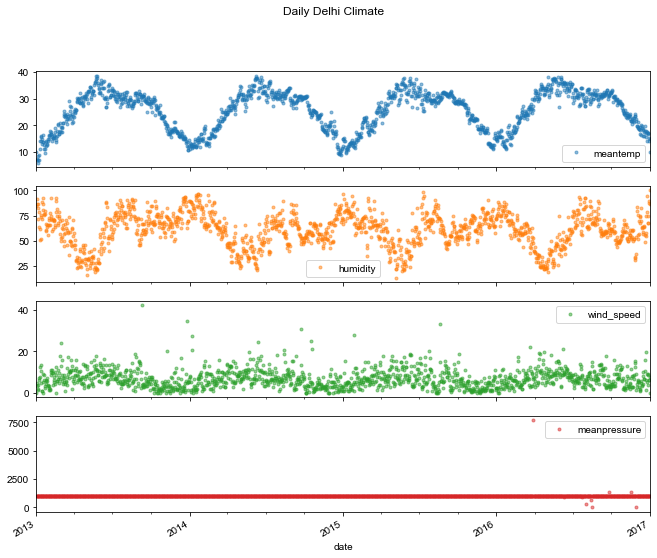

In [4]:
cols_plot = ['meantemp','humidity', 'wind_speed', 'meanpressure']
axes = df[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), title='Daily Delhi Climate',subplots=True)
sns.set(rc={'figure.figsize':(17, 4)})

SAX is a transformation method to convert a numeric vector to a symbolic representation, i.e., a sequence of symbols from a predefined alphabet a. SAX first computes the Piecewise Aggregate Approximation (PAA) of a time series in the time domain, then transforms this approximation to a symbolic representation.
For the symbolic representation, I will only consider mean temperature parameter and I explain step by step how to transform to SAX respresantaiton. First of all, time series here the mean temperature per day and in total we have 1462 days. This number is our t value and X(t) is the mean temperature of respective day.
<br>
An important decision point when working with a sample of data is whether to use parametric or nonparametric statistical methods. This is an important step because if a data sample is not Gaussian, then the assumptions of parametric statistical tests are violated and nonparametric statistical methods must be used. 
<br>
The normal Q-Q plot is used to test a distribution’s fit to a normal distribution. If the fit is perfect then the data will appear as a perfect diagonal line where the x and y values are the same. However, as it is illustrated in below graph, my data is a little narrower on the right side and a little more extended on the left. It looks close to a Gaussian distribution, but I will assume as it is a Gaussian distribution to continue with SAX represantation.

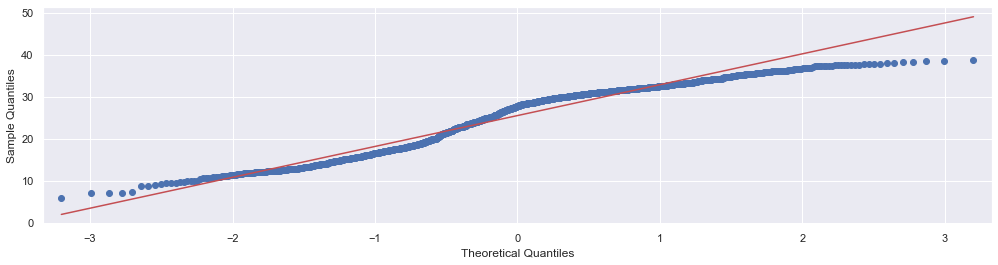

In [5]:
# q-q plot
qqplot(df['meantemp'], line='s')
plt.show()

Next step is to normalise time series data which have a Gaussian distribution. For this step I have used znorm function from saxpy library. z-normalization is a common to the field of time series patterns mining preprocessing step proposed by Goldin & Kannellakis which helps downstream analyses to focus on the time series structural features.

In [6]:
df_znorm = znorm(df['meantemp']) #normalization
df_znorm.reset_index(drop=True, inplace=True)

In [7]:
len(df_znorm) #n

1462

PAA (Piecewise Aggregate Approximation) is then followed by a discretisation step which replaces each value of the PAA with a corresponding symbol. The symbol is selected from the alphabet based on the interval in which the value falls. There are a intervals, as many as the size of the alphabet. Each interval is associated with a symbol from the alphabet. Assuming that the time series is normal distributed, the intervals are divided under the normal distribution (i.e. N(0,1)) with equal probability. It can be simply determined the "breakpoints" that will produce a equal-sized areas under Gaussian curve.
<br>
These breakpoints can be obtained by looking up a statistical table and can be used to discretise the time series where the coefficients below the smallest breakpoint are mapped to the letter "a"  while the coefficients greater than or equal to the smallest breakpoint and less than the second breakpoint are assigned to the letter "b" and so on. Note that in this example the 4 symbols, "a", "b", "c" and "d" are approximately equiprobable as I desired.
<br>
<br>
To convert a time series of an arbitrary length to SAX we need to define the alphabet cuts. Saxpy retrieves cuts for a normal alphabet via cuts_for_asize function which yields an array:

In [8]:
cuts_for_asize(4) #breakpoints

array([      -inf, -0.6744898,  0.       ,  0.6744898])

Dimensinonality Reduction Via PAA
<br>
<br>
In order to reduce the time series from n dimensions to w dimensions, the data is divided into w
equal sized “frames”. The mean value of the data falling within a frame is calculated and a vector of these
values becomes the data-reduced representation. In this case, n is 1467 and w has been choosen as 50. Below array shows PAA values.

In [9]:
df_paa_50 = paa(df_znorm, 50) #paa_representation, w
df_paa_50

array([-1.85559498, -1.19150463, -0.37617003,  0.3674816 ,  1.08335685,
        1.00624098,  0.75087713,  0.5238927 ,  0.68436699,  0.3204441 ,
       -0.63118026, -1.09590849, -1.69228219, -1.45210517, -1.08521009,
       -0.04645719,  0.59025252,  1.0517771 ,  1.09898603,  0.83360214,
        0.72875449,  0.64003984, -0.02125259, -0.75901018, -1.54376825,
       -1.7539618 , -0.93366986, -0.54788214,  0.2854727 ,  1.04350637,
        1.02314382,  0.73568032,  0.56750968,  0.82586684,  0.41113987,
       -0.37769869, -1.14624121, -1.47033103, -1.35498159, -0.34261937,
        0.44456643,  1.11850936,  1.37117482,  1.07926233,  0.73609578,
        0.71508212,  0.84518723,  0.33692765, -0.41132566, -1.13004239])

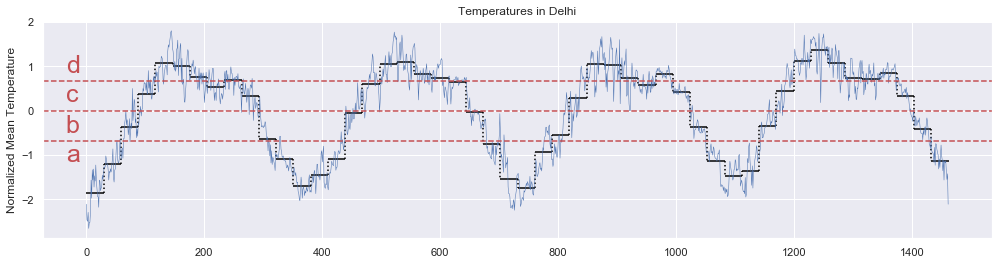

In [10]:
breakpoints=cuts_for_asize(4)
fig, ax = plt.subplots()

ax.plot(df_znorm, linewidth=0.5)

for i in range(len(breakpoints)):
    ax.axhline(y=breakpoints[i], linestyle='--', color='r')

paa=df_paa_50
n=len(df_znorm)
w=len(paa)
   
for i in range(len(paa)):
    ax.hlines(y=paa[i], xmin=n/w*i, xmax=n/w*(i+1), linestyle='-', color='black')

for i in range(len(paa)-1):
    ax.vlines(x=n/w*(i+1), ymin=paa[i], ymax=paa[i+1], linestyle='dotted', color='black')
    
ax.set_title('Temperatures in Delhi')
ax.set_ylabel('Normalized Mean Temperature')

ax.annotate('d', xy=(-35, 1), fontsize=25,color='r', verticalalignment='center')
ax.annotate('c', xy=(-35, 0.35), fontsize=25,color='r',verticalalignment='center')
ax.annotate('b', xy=(-35, -0.35),fontsize=25,color='r',verticalalignment='center')
ax.annotate('a', xy=(-35, -1),fontsize=25,color='r',verticalalignment='center')

sns.set(rc={'figure.figsize':(13, 4)})

Above graphical interface illustrates how I have obtained SAX representation for this time series. The normalized original data which is shown in blue color is split into frames (w=50) and the mean of the values in the frame are computed (Paa values) shown in black color. In this way, I discretized the times series from 1467 to 50 by using PAA approximation.Then using predetermined breakpoints which are shown in red dashlines, I mapped the PAA coefficients into SAX symbol (a,b,c,d). Each value of PAA is assigned to respective letter regarding to in which interval they are fallen. 

In [11]:
sax=ts_to_string(df_paa_50, cuts_for_asize(4))
print('The symbolic represantation of the time series is {} '.format(sax))

The symbolic represantation of the time series is aabcdddcdcbaaaabcddddcbaaaabcdddcdcbaaabcddddddcba 


In [14]:
frequencies = {} 
  
for char in sax: 
   if char in frequencies: 
      frequencies[char] += 1
   else: 
      frequencies[char] = 1

# Show Output
print ("Per SAX symbol frequency in '{}' is :\n {}".format(sax, str(frequencies)))

Per SAX symbol frequency in 'aabcdddcdcbaaaabcddddcbaaaabcdddcdcbaaabcddddddcba' is :
 {'a': 14, 'b': 8, 'c': 10, 'd': 18}
